# SIGLE: Selective Inference in Generalized Linear models through conditional MLE
# The case of the Sparse Logistic Regression


### Authors: Quentin Duchemin & Yohann De Castro

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from inverse_map import inverse_map, train_network
import torch
import scipy
import scipy as sc
import scipy.stats
from PSIGLL import *

In [424]:
from ipyparallel import Client

c = Client()
print(c.ids)
dview = c[:]
import numpy as np

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


# I) SEI-SLR

In [33]:
n,p = 11,10
X = np.random.normal(0,1,(n,p))
X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
theta = np.zeros(p)
theta[:2] = [1,1]
def logtemp(x):
    return (0.4/np.log(x))
nb_expe = 1

settings= [{'n':n,
            'p':p,
            'X':X,
            'theta':theta,
            'cross_val':False,
            'lamb':0.6,
            'temperature':logtemp, 
            'nb_expe':nb_expe, 
            'file':'test/'}]

SEI_SLR(settings=10*settings, conditioning_signs=False, total_length_SEISLR_path=1500,compute_pvalues=False)

In [2]:
path = 'test/'

# Finding all the saved experiments
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
indexes = []
for file in onlyfiles:
    if file[:6]=='last_y':
        indexes.append(file[6:-4])
print('Total of number of simulated annealing:', len(indexes))

Total of number of simulated annealing: 10


### 1) Visualization of results

In [35]:
index = indexes[1]

M = np.load(path+index+'M.npy')
X = np.load(path+index+'X.npy')
lamb = np.load(path+index+'lamb.npy')[0]
theta_obs = np.load(path+index+'theta_obs.npy')
sig = np.load(path+index+'sig.npy')
yobs = np.load(path+index+'yobs.npy')
if n<=17:
    bnM_admi, ls_states_admissibles = compute_selection_event(theta_obs,X,yobs,lamb,conditioning_signs=False)
else:
    ls_states_admissibles = SEI_by_sampling(sig, X, lamb, M)

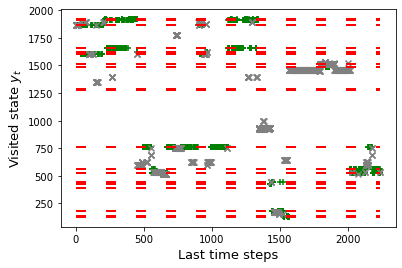

In [36]:
last_visited_states(indexes,path,ls_states_admissibles)

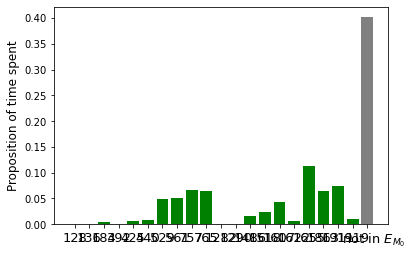

In [37]:
histo_time_in_selection_event(indexes, path, ls_states_admissibles)

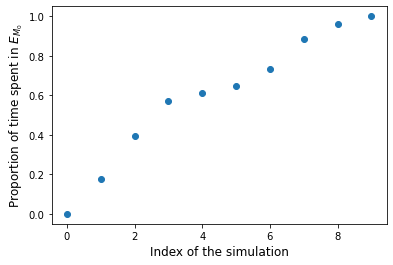

In [38]:
time_in_selection_event(indexes, path, ls_states_admissibles)

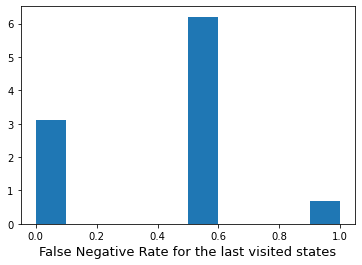

In [39]:
ls_FNR = np.load('test/FNR'+index+'.npy')
hist = plt.hist(ls_FNR,density=True)
plt.ylabel('')
plt.xlabel('False Negative Rate for the last visited states', fontsize=13)
plt.show()

# I) CDF of P-values

##### Data

In [48]:
n,p = 200,10
lamb = 1

d = 2
theta = 0*np.ones(d)
truetheta = np.zeros(p)
truetheta[:d] = theta

np.random.seed(1)
X = np.random.normal(0,1,(n,p))
#X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
matXtrue = X[:,:d]

sig = sigmoid(matXtrue @ theta)
yobs = np.random.rand(n) <= sig
model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
model.fit(X, yobs)
theta_obs = model.coef_[0]
M = np.where( np.abs(theta_obs) > 1e-5)[0]
print('Selected support: ', M)
print('Size selected support: ', len(M))


# definition of the null distribution
thetanull = np.copy(truetheta)
signull = sigmoid(X @ thetanull)

Selected support:  [0 1 2 3 4 5 7 8 9]
Size selected support:  9


### <span style="color:red">SEI by sampling ?</span>
Set *SEI_sampling* to *True* in order to approximate the selection event by sampling. Otherwise, the full state space will be visited to compute exactly the selection event. 

If $n\geq17$, *SEI_sampling* should be set to *True* to avoid computational issue.

In [49]:
SEI_sampling = True
if SEI_sampling:
    states = SEI_by_sampling(sig, X, lamb, M)

1  states in the selection event found so far
21  states in the selection event found so far
41  states in the selection event found so far
61  states in the selection event found so far
81  states in the selection event found so far
101  states in the selection event found so far
121  states in the selection event found so far
141  states in the selection event found so far
161  states in the selection event found so far
181  states in the selection event found so far
201  states in the selection event found so far
221  states in the selection event found so far
241  states in the selection event found so far
261  states in the selection event found so far
281  states in the selection event found so far
301  states in the selection event found so far
321  states in the selection event found so far
341  states in the selection event found so far
361  states in the selection event found so far
381  states in the selection event found so far
401  states in the selection event found so fa

##### Compute the conditional distribution of the observations

In [50]:
if SEI_sampling:
    probasalt, states = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False,states=states)
else:
    probasalt, states = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False)
probasnull, states = true_conditional_distribution(theta_obs,X,yobs,lamb,thetanull,conditioning_signs=False,states=states)
print('Number of states in the selection event: ', len(states))

Number of states in the selection event:  3701


##### Computing $\bar \pi ^{\pi ^0}$ and training the NN aiming at computing $\Psi=\Xi^{-1}$

In [51]:
idxs_null = np.random.choice([i for i in range(len(states))], size=300, p=probasnull)
lsy = []
for i in idxs_null:
    lsy.append(np.array(states[i]))
n,p = np.shape(X)
matXtrue = X[:,M]
tildeGN_12, barpi = params_saturated(signull, matXtrue, lsy)
net, loss_values = train_network(matXtrue,max(1,truetheta[0]),nb_epochs=6000)

In [52]:
probasalt

array([0.0002702, 0.0002702, 0.0002702, ..., 0.0002702, 0.0002702,
       0.0002702])

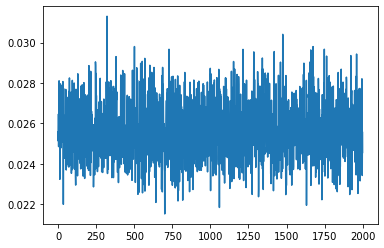

In [53]:
plt.plot(loss_values[4000:])

##### P-values from the weak learner

In [54]:
lspvals_naive = pval_weak_learner(probasalt,probasnull,states,barpi)

##### P-values from SIGLE

In [55]:
lspvals_selec, lspvals_sat = pval_SIGLE(states, probasalt, X, M, barpi, net, use_net_MLE=False, l2_regularization=10000)

##### P-values from Taylor & Tibshirani '18

In [56]:
lspvals_tay = pval_taylor(probasalt,states,X,lamb,M,show_distributions=False, thetanull = thetanull)

##### RESULTS

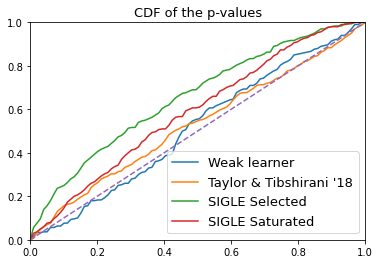

In [57]:
lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_selec, lspvals_sat]
names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Selected', 'SIGLE Saturated']
plot_cdf_pvalues(lists_pvalues, names, name_figsave=None)

/opt/anaconda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

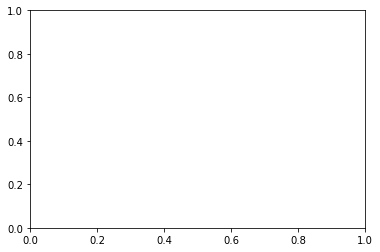

In [43]:
matXtrue = X[:,M]
rho = matXtrue.T @ barpi.T
tildetheta = net(torch.from_numpy(rho.T).float())
tildetheta = tildetheta.detach().numpy()
tildeGN = matXtrue.T @ np.diag(barpi*(np.ones(n)-barpi)) @ matXtrue
usvd,s,vt = np.linalg.svd(tildeGN)
tildeGN_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
GNtilde = matXtrue.T @ np.diag(sigmoid1(matXtrue @ tildetheta)) @ matXtrue
VN = tildeGN_12 @ GNtilde

idxs = np.random.choice([i for i in range(len(states))], size=600, p=probasalt)
lsstat = []
u  = np.random.normal(0,1,len(M))
u /= np.linalg.norm(u)
u = np.zeros(len(M))
u[0] = 1
lspvals_selec = []
for i in idxs:
    y = np.array(states[i])
    # selected
    model = LogisticRegression(C=10000, solver='liblinear', fit_intercept=False)
    model.fit(matXtrue, y)
    theta = model.coef_[0]
    stat = u.T @ VN @ (theta - tildetheta)
    lsstat.append(stat)
    stat2 = np.linalg.norm( VN @ (theta - tildetheta))**2
    lspvals_selec.append(1-scipy.stats.chi2.cdf(stat2, len(M)))
a= plt.hist(lsstat, density=True, alpha=0.2, bins=30)
b = np.random.normal(0,1,500)
c = plt.hist(b,density=True, bins=30, alpha=0.2, label='true gaussian')
plt.legend()

(array([143.,  66.,  70.,  50.,  58.,  58.,  50.,  28.,  46.,  31.]),
 array([2.82568761e-08, 9.94366987e-02, 1.98873369e-01, 2.98310040e-01,
        3.97746710e-01, 4.97183381e-01, 5.96620051e-01, 6.96056722e-01,
        7.95493392e-01, 8.94930063e-01, 9.94366733e-01]),
 <BarContainer object of 10 artists>)

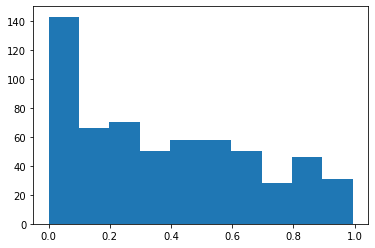

In [52]:
plt.hist(lspvals_selec)

In [43]:
rho = matXtrue.T @ barpi
tildetheta = net(torch.from_numpy(rho.T).float())
the = tildetheta.detach().numpy()
print(rho, matXtrue.T @sigmoid(matXtrue @ (the)), the)

[ 2.95106503  1.34594412  3.69293962 11.34059979 -2.09303163 -8.17182938
  6.57100818 10.39074538  8.82415578 -0.69201638] [  3.98469343   1.13431639   4.82508671  13.77565202  -3.43000374
 -10.17042878   8.19310948  12.05403091   9.40121492  -0.48682415] [ 0.03569615  0.00643739  0.01562171  0.04982305 -0.0128373  -0.03444312
  0.02643775  0.04233687  0.00288651  0.00059938]


In [271]:
barpi, tildeGN_12, tildetheta

(array([0.53666667, 0.52      , 0.49666667, 0.51666667, 0.52666667,
        0.49      , 0.54      , 0.45333333, 0.48      , 0.46666667,
        0.50666667, 0.49666667, 0.54      , 0.52333333, 0.51333333,
        0.47333333, 0.47666667, 0.47      , 0.52333333, 0.51333333,
        0.43      , 0.49      , 0.53333333, 0.49      , 0.51666667,
        0.47666667, 0.48      , 0.52      , 0.48      , 0.48333333,
        0.42666667, 0.56666667, 0.51      , 0.51666667, 0.44      ,
        0.45666667, 0.51666667, 0.56      , 0.42      , 0.45      ,
        0.52      , 0.43333333, 0.47      , 0.5       , 0.54333333,
        0.53666667, 0.47666667, 0.51666667, 0.49333333, 0.53666667,
        0.41666667, 0.48333333, 0.50666667, 0.56333333, 0.52333333,
        0.53666667, 0.56      , 0.54333333, 0.53      , 0.43666667,
        0.48666667, 0.49333333, 0.46333333, 0.48      , 0.57      ,
        0.52      , 0.46666667, 0.48666667, 0.5       , 0.5       ,
        0.52      , 0.51666667, 0.49666667, 0.45

In [205]:
net, loss_values = train_network(matXtrue,max(5,truetheta[0]),nb_epochs=4000)

In [70]:
for j in range(20):
    print(compute_proba(states[j],0.5*np.ones(n)))

0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016
0.00024414062500000016


In [86]:
probasalt,probasnull

(array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025]),
 array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
        0.025, 0.025, 0.025, 0.025]))

In [50]:
matXtrue = X[:,M]

idxs = np.random.choice([i for i in range(len(states))], size=300, p=probasalt)

mean = np.zeros(n)
norma = 0
for j in idxs[:250]:
    y = states[j]
    mean += np.array(y) * probasalt[j]
    norma += probasalt[j]
    rho = matXtrue.T @ y
    tildetheta = net(torch.from_numpy(rho.T).float())
    the = tildetheta.detach().numpy()
    #print(rho, matXtrue.T @ sigmoid(matXtrue @ the),the)
    
    model = LogisticRegression(C=10000, solver='liblinear', fit_intercept=False)
    model.fit(X, y)
    theta_obs = model.coef_[0]
    print('THETA', theta_obs)
print(mean / norma)

THETA [-2.4292725  -0.78268468 -0.04298107  0.53203826 -0.59960704  0.75249342
  2.79633751 -2.94799217 -2.91936599 -0.32619623]
THETA [ 3.6241576   0.34818906  2.20407773 -1.162136   -3.72841418 -2.66561938
  1.72496294  6.28958895  0.92792353 -0.46776457]
THETA [ 0.37781537 -1.93897349 -0.43852471 -3.14842005 -2.00530106  0.50656854
 -0.25743511 -3.34971615 -0.83872254 -2.08932421]
THETA [-1.92477758  1.55562905  2.14136139  0.19188669 -1.29121507 -1.83570471
  2.02435632  2.6337535  -1.73800972  2.01678597]
THETA [-1.05014392  0.46895105  0.90549386  0.15050333 -0.73076536 -0.81798558
 -0.33117427  3.44603976 -1.23052129 -1.30669463]
THETA [ 1.42307647 -1.34016215  2.65640707  0.23878077 -2.26195679 -2.14791421
 -1.66161998  2.87344028  0.34033719  1.68905939]
THETA [ 1.01747617  0.05810585 -1.4785238  -1.61172776 -0.61104704 -1.74740059
 -0.48549605 -2.77899975 -0.26975459  1.17721672]
THETA [ 1.57985187  0.71605099 -1.0046086   2.75191528 -0.69327224  2.62607362
  1.81126434  3.82